This notebook:
1. Defines the folder paths to our data.  
2. Loads **db.json** (symbol metadata) that contains the data of each image.
3. Loops through every image and writes a one-sentence explanation.  
4. Saves the list of explanations as a new JSON file.

In [ ]:
from pathlib import Path
import os
os.environ["DATA"] = os.path.expanduser("~/")
db_dir = os.environ["DATA"] + "PatImgXAI_data/db0.1.4_6x6/"
db = os.path.join(db_dir, "datasets")
db_json = os.path.join(db_dir, "db.json")

Create a pipeline for all rules

In [61]:
#color code
HEX_TO_NAME = {
    "#7AB0CD": "blue",
    "#F4D67B": "yellow",
    "#F86C62": "red",
    "#87C09C": "green",
}
def describe_symbol(symbol):
    """
    This function takes a symbol dictionary containing 'color', 'shape', and 'pos' keys
    and generate a description.
    """
    color_name = HEX_TO_NAME.get(symbol['color'], symbol['color'])
    position = symbol['pos'] #(column,row)

    #convert the column number into letter, showing cheesboard like coordinate
    column_letter = chr(ord('A') + position[0])
    row_number = position[1] + 1
    position_label = f"{column_letter}{row_number}"
    return f"a {color_name} {symbol['shape']} at position {position_label}"

Rule functions

In [62]:
def generate_bluediagonal_explanation(img_content):
    """
    Generates an explanation for the 'bluediagonal' rule.
    """
    symbols_on_diagonal = []
    all_diagonal_symbols_blue = True

    for c in img_content['content']:
        if c['pos'][0] == c['pos'][1]:
            symbols_on_diagonal.append(c)
            if c['color'] != '#7AB0CD':
                all_diagonal_symbols_blue = False

    if not symbols_on_diagonal:
        return "This is not blue diagonal because there are no symbols on the main diagonal."

    symbols_list = "; ".join(describe_symbol(s) for s in symbols_on_diagonal)
    count = len(symbols_on_diagonal)

    if all_diagonal_symbols_blue:
        return f"This respects the blue diagonal rule because {count} blue symbol(s) form a diagonal. The diagonal symbols are: {symbols_list}."
    else:
        return f"This does not respect the blue diagonal rule because the main diagonal has {count} symbol(s), but not all are blue. The symbols are: {symbols_list}."

In [63]:
def generate_exactly_6_red_symbols_explanation(img_content):
    """
    Generates a detailed explanation for the 'exactly_6_red_symbols' rule.
    """
    red_symbols = []
    for s in img_content['content']:
        if s['color'] == '#F86C62':
          red_symbols.append(s)

    count = len(red_symbols)
    symbols_list = ", ".join(describe_symbol(s) for s in red_symbols)

    if count == 6:
        return f"This respects the exactly 6 red symbols rule because there are exactly 6 red symbols. The symbols are: {symbols_list}."
    else:
        return f"This does not respect the exactly 6 red symbols rule because there are {count} red symbols, not 6. The red symbols found are: {symbols_list}."


In [64]:
def generate_exactly_6_squares_explanation(img_content):
    """
    Generates a detailed explanation for the 'exactly_6_squares' rule.
    """
    squares=[]
    for s in img_content['content']:
        if s['shape'] == 'square':
          squares.append(s)

    count = len(squares)
    symbols_list = ", ".join(describe_symbol(s) for s in squares)

    if count == 6:
        return f"This respects the exactly 6 red squares rule because there are exactly 6 squares. The squares are: {symbols_list}."
    else:
        return f"This does not respect the exactly 6 red squares rule because there are {count} squares, not 6. The squares found are: {symbols_list}."

In [65]:
def generate_twice_as_many_green_as_red_explanation(img_content):
    """
    Generates a detailed explanation for the 'twice_as_many_green_as_red' rule.
    """
    green_symbols =[]
    red_symbols = []
    for s in img_content['content']:
        if s['color'] == '#87C09C':
          green_symbols.append(s)
    for s in img_content['content']:
        if s['color'] == '#F86C62':
          red_symbols.append(s)

    green_count = len(green_symbols)
    red_count = len(red_symbols)
    symbols_list = ", ".join(describe_symbol(s) for s in green_symbols)
    symbols_list2 = ", ".join(describe_symbol(s) for s in red_symbols)
    if green_count == red_count*2:
         return f"This respects the twice as many as green because the rule is met with {green_count} green and {red_count} red symbols. Green symbols: [{symbols_list}]. Red symbols: [{symbols_list2}]."
    else:
         return f"This does not respect the twice as many as green because the rule is not met with {green_count} green and {red_count} red symbols. Green symbols: [{symbols_list}]. Red symbols: [{symbols_list2}]."

In [66]:
RULE_EXPLANATION_FUNCTIONS = {
    "bluediagonal": generate_bluediagonal_explanation,
    "exactly_6_squares": generate_exactly_6_squares_explanation,
    "exactly_6_red_symbols": generate_exactly_6_red_symbols_explanation,
    "twice_as_many_green_as_red": generate_twice_as_many_green_as_red_explanation,
}

Generate dataset with explanation

In [67]:
import json
# db_json_path = os.path.join(db_dir, "db.json")  # db_dir already defined
with open(db_json, "r") as f:
    db_dict = json.load(f)

In [68]:
import pandas as pd
import os

def generate_dataset_explanation(rule_name, dataset_filename, db, db_dict):
    """
    Generates a dataset with explanations for a given rule.
    :param rule_name: The name of the rule.
    :param dataset_filename: The name of the dataset file.
    :param db: path to the root directory of the dataset.
    :param db_dict: load db.json which is the database dictionary.
    """
    print(f"--- Processing {dataset_filename} dataset for rule: {rule_name} ---")
    explanation_func = RULE_EXPLANATION_FUNCTIONS.get(rule_name)
    if not explanation_func:
        print(f"Error: No explanation function found for rule '{rule_name}'. Skipping.")
        return

    csv_file = os.path.join(db, dataset_filename)
    out_name   = dataset_filename.replace(".csv", "_explanations.json")
    output_json = os.path.join(db, out_name)

    # Check if input file exists
    if not os.path.exists(csv_file): # Use os.path.exists() for strings
        print(f"Warning: Input file not found at {csv_file}. Skipping.")
        return

    df = pd.read_csv(csv_file)
    results = []

    for _, row in df.iterrows():
        img_path = row["path"]
        label = row["class"]
        img_id = Path(img_path).stem

        if img_id in db_dict:
            explanation = explanation_func(db_dict[img_id])
            results.append({
                "path": img_path,
                "class": int(label),
                "explanation": explanation
            })
        else:
            print(f"Warning: {img_id} not in db.json – skipping.")

    # Ensure output directory exists
    output_dir = Path(output_json).parent
    output_dir.mkdir(parents=True, exist_ok=True)

    with open(output_json, "w") as f:
        json.dump(results, f, indent=2)
    print(f"Successfully generated explanations. Saved to {output_json}\n")

In [ ]:
# generate_dataset_explanation("exactly_6_red_symbols", train_dataset_filename, db_dir, db_dict)

--- Processing bluediagonal_train.csv dataset for rule: exactly_6_red_symbols ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/bluediagonal_train_explanations.json



In [69]:
def run_all_files(rule_name, filename, db, db_dict):
  """
  Processes multiple dataset files to generate explanations based on a specified rule.
  :param rule_name: The name of the rule.
  :param filename: A list of filenames to process.
  :param db: path to the root directory of the database.
  :param db_dict: load db.json which is the database dictionary.
  """
  for fname in filename:
    generate_dataset_explanation(rule_name, fname, db, db_dict)

In [70]:
run_all_files("bluediagonal",["bluediagonal_train.csv", "bluediagonal_test.csv", "bluediagonal_valid.csv",], db, db_dict)

--- Processing bluediagonal_train.csv dataset for rule: bluediagonal ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/bluediagonal_train_explanations.json

--- Processing bluediagonal_test.csv dataset for rule: bluediagonal ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/bluediagonal_test_explanations.json

--- Processing bluediagonal_valid.csv dataset for rule: bluediagonal ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/bluediagonal_valid_explanations.json



In [71]:
run_all_files("exactly_6_red_symbols", ["exactly_6_red_symbols_train.csv", "exactly_6_red_symbols_test.csv", "exactly_6_red_symbols_valid.csv"], db, db_dict)

--- Processing exactly_6_red_symbols_train.csv dataset for rule: exactly_6_red_symbols ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_red_symbols_train_explanations.json

--- Processing exactly_6_red_symbols_test.csv dataset for rule: exactly_6_red_symbols ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_red_symbols_test_explanations.json

--- Processing exactly_6_red_symbols_valid.csv dataset for rule: exactly_6_red_symbols ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_red_symbols_valid_explanations.json



In [72]:
run_all_files("exactly_6_squares", ["exactly_6_squares_train.csv", "exactly_6_squares_test.csv", "exactly_6_squares_valid.csv"], db, db_dict)

--- Processing exactly_6_squares_train.csv dataset for rule: exactly_6_squares ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_squares_train_explanations.json

--- Processing exactly_6_squares_test.csv dataset for rule: exactly_6_squares ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_squares_test_explanations.json

--- Processing exactly_6_squares_valid.csv dataset for rule: exactly_6_squares ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_squares_valid_explanations.json



In [73]:
run_all_files("twice_as_many_green_as_red", ["twice_as_many_green_as_red_train.csv", "twice_as_many_green_as_red_test.csv", "twice_as_many_green_as_red_valid.csv"], db, db_dict)

--- Processing twice_as_many_green_as_red_train.csv dataset for rule: twice_as_many_green_as_red ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/twice_as_many_green_as_red_train_explanations.json

--- Processing twice_as_many_green_as_red_test.csv dataset for rule: twice_as_many_green_as_red ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/twice_as_many_green_as_red_test_explanations.json

--- Processing twice_as_many_green_as_red_valid.csv dataset for rule: twice_as_many_green_as_red ---
Successfully generated explanations. Saved to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/twice_as_many_green_as_red_valid_explanations.json



Display image

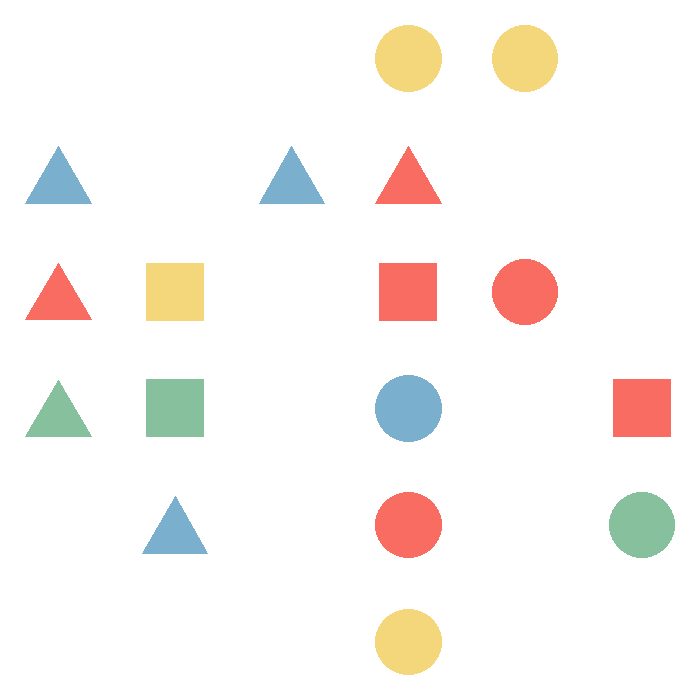

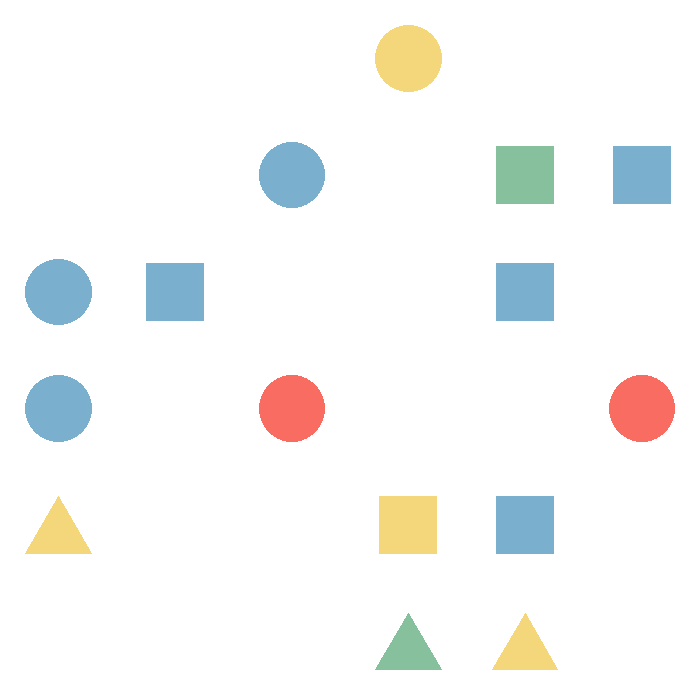

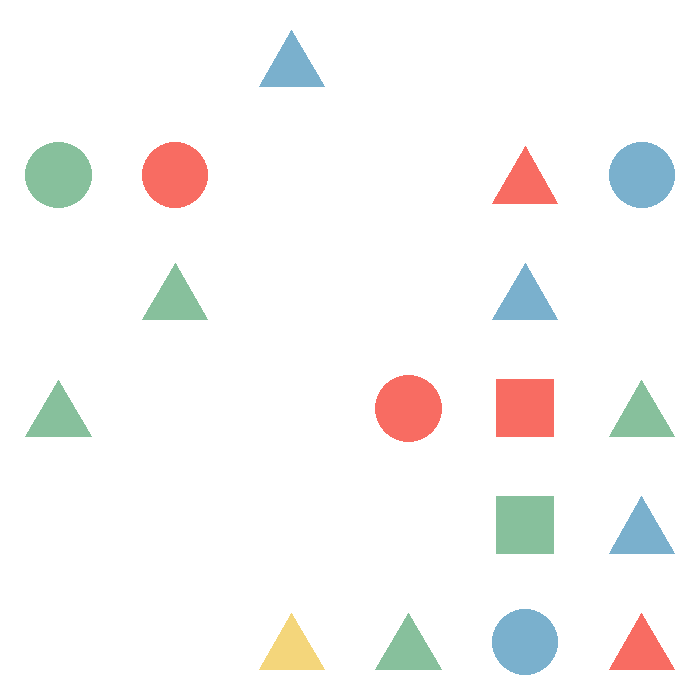

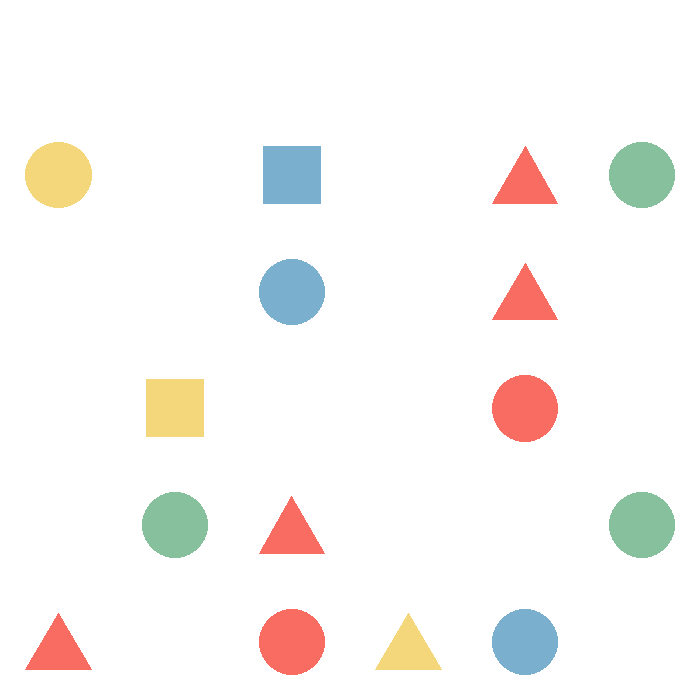

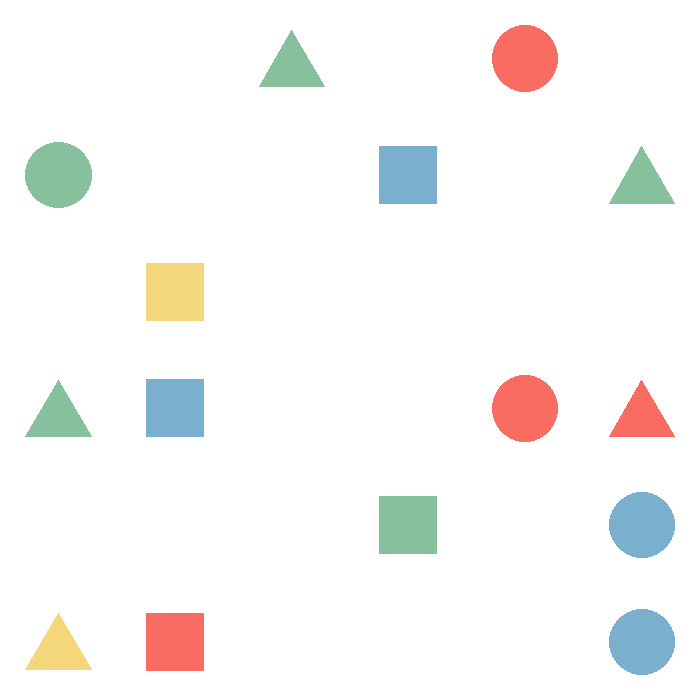

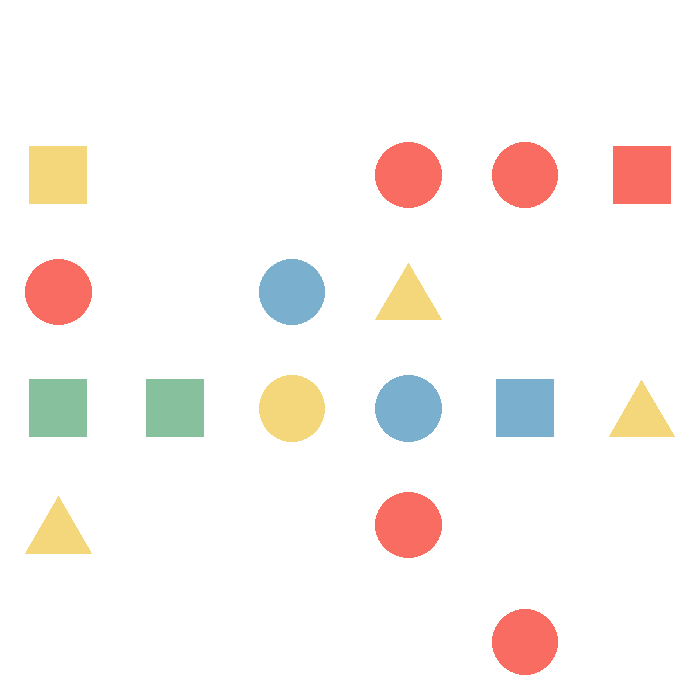

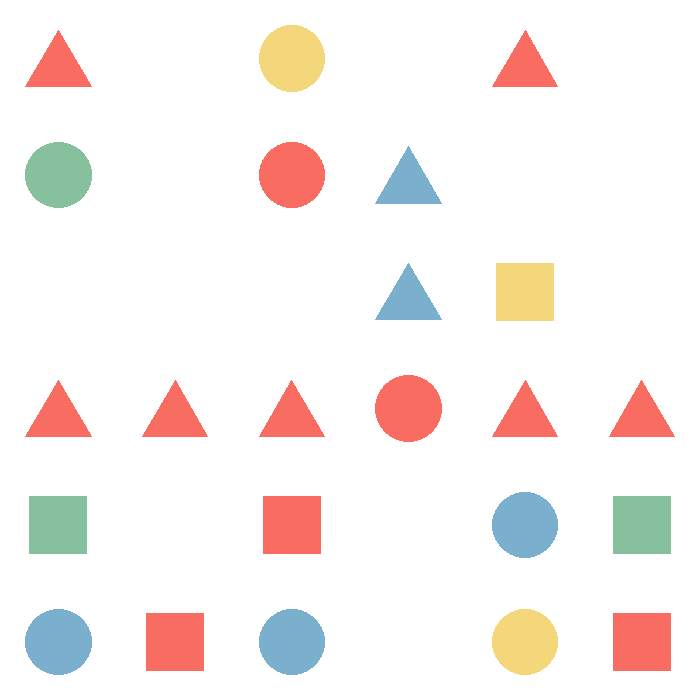

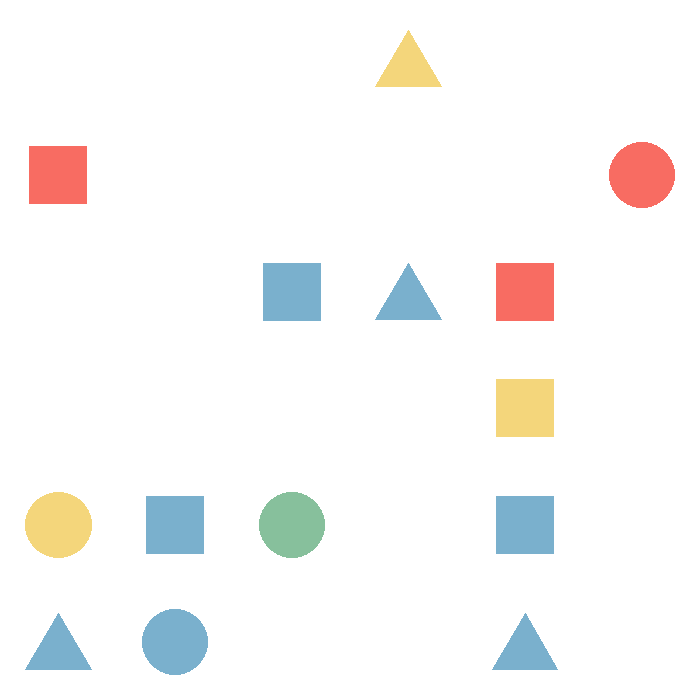

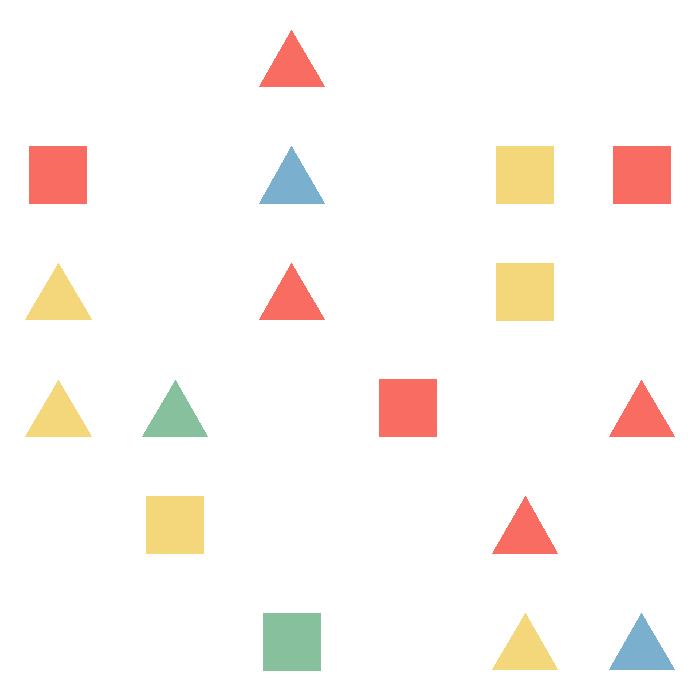

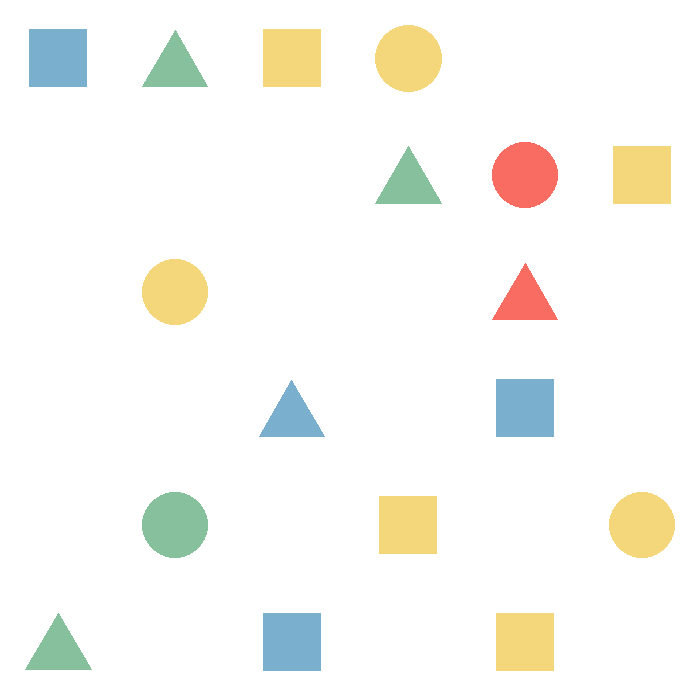

In [ ]:
from PIL import Image
from IPython.display import display, HTML
import os
import json # Import json here as well for completeness

image_dir = os.path.join(db_dir, "img")

# Specify the explanation file for the blue diagonal test dataset
explanation_filename = "bluediagonal_test_explanations.json"
output_json_path = os.path.join(db, explanation_filename)

# Check if the explanation file exists before attempting to open
if not os.path.exists(output_json_path):
    print(f"Error: Explanation file not found at {output_json_path}. Please ensure you have generated it.")
else:
    with open(output_json_path) as f:
        explanations = json.load(f)

    # ------------------------------------------------------------------
    # 3.  show some examples
    # ------------------------------------------------------------------
    MAX_SHOW = 10                               # ← change or remove the limit
    for item in explanations[:MAX_SHOW]:
        # Construct the full image path correctly
        img_path = os.path.join(image_dir, Path(item["path"]).name)

        # print(f"Attempting to open image: {img_path}") # Print the path being accessed

        caption  = f"<b>Class {item['class']}</b> — {item['explanation']}"

        # display the image and its caption
        try:
            display(Image.open(img_path).convert("RGB"))
            display(HTML(caption))
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")

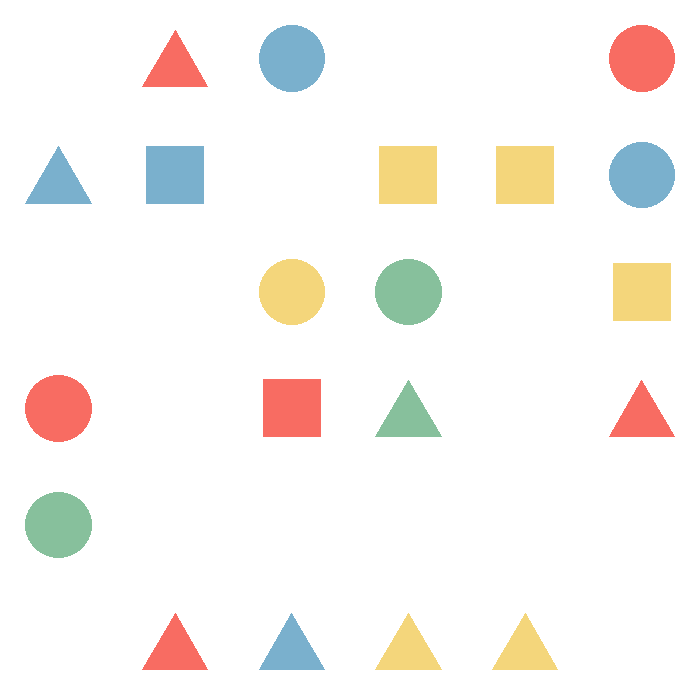

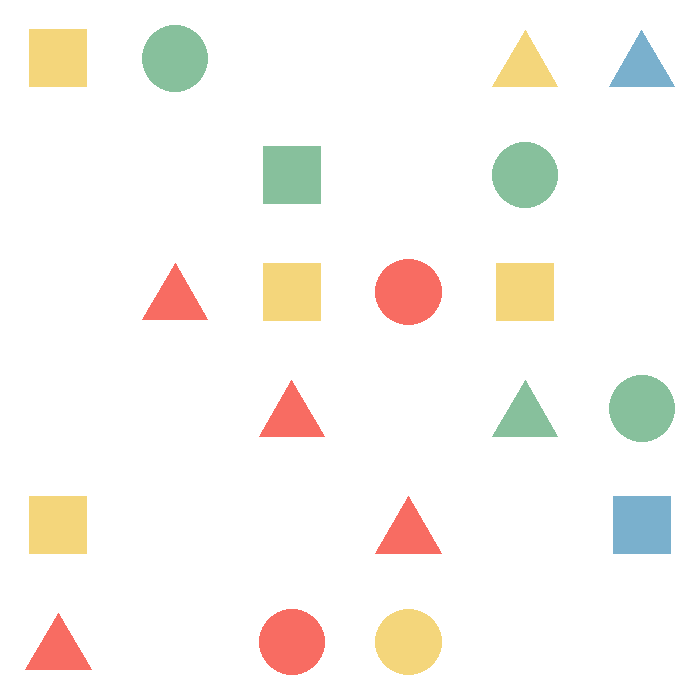

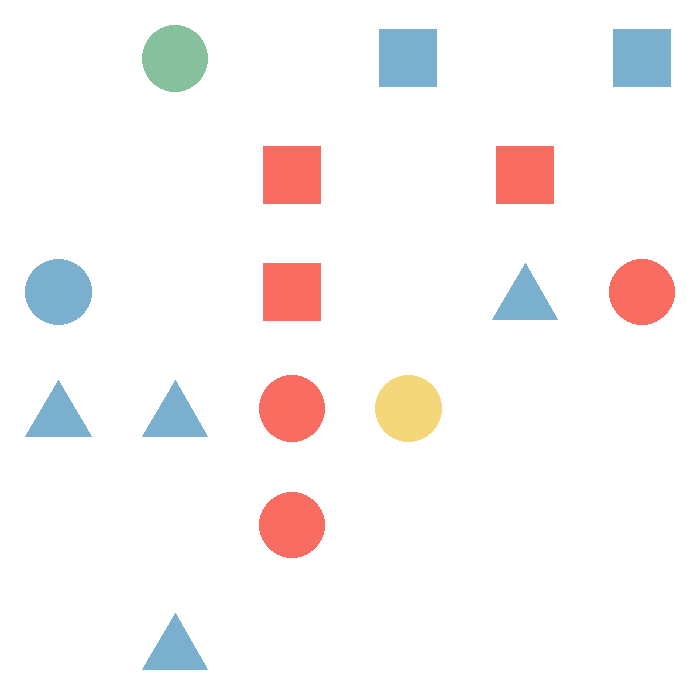

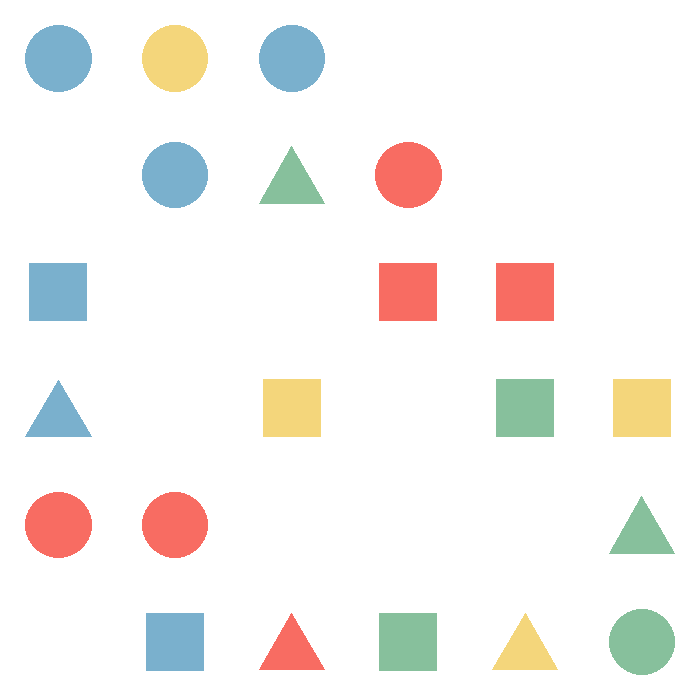

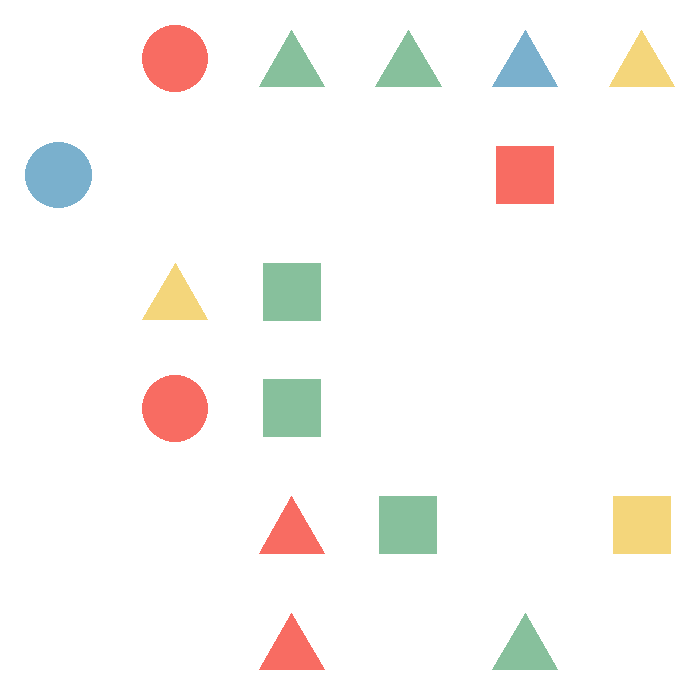

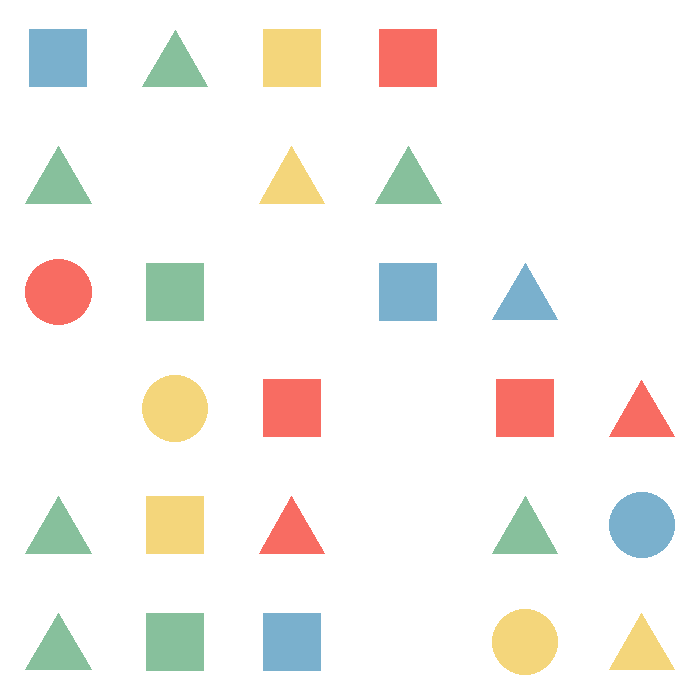

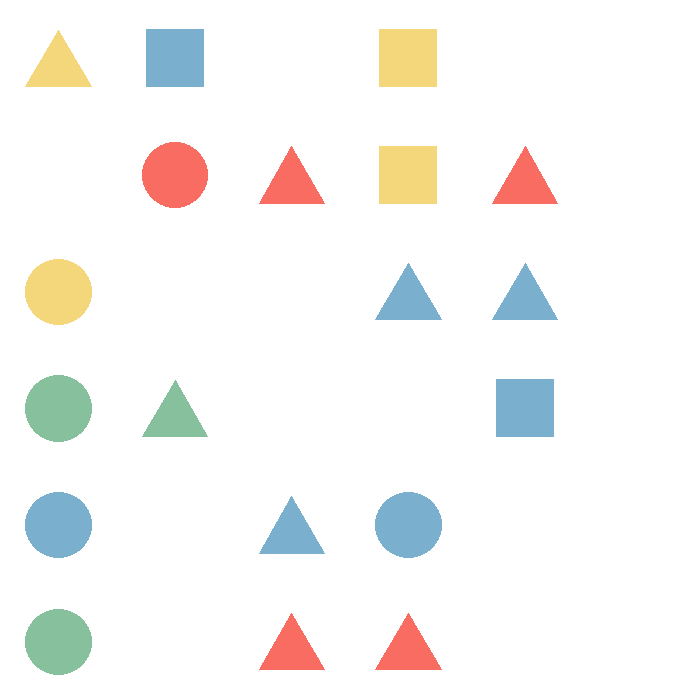

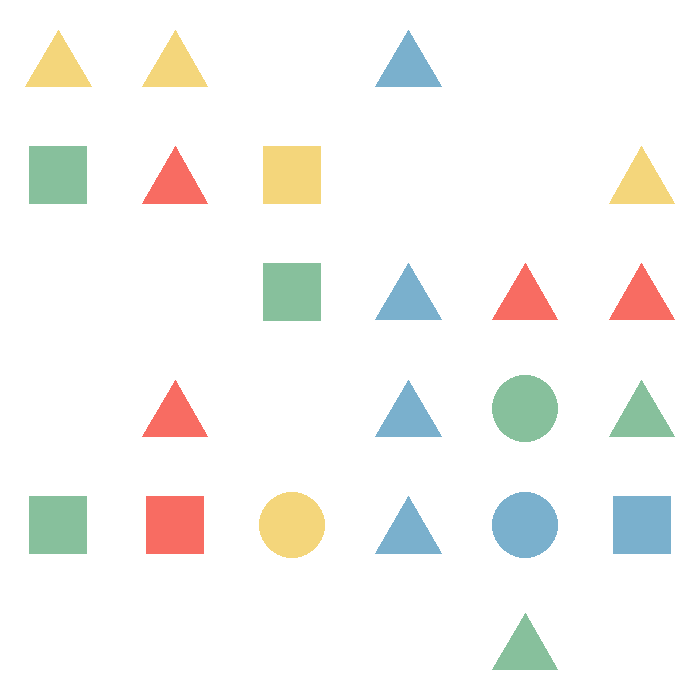

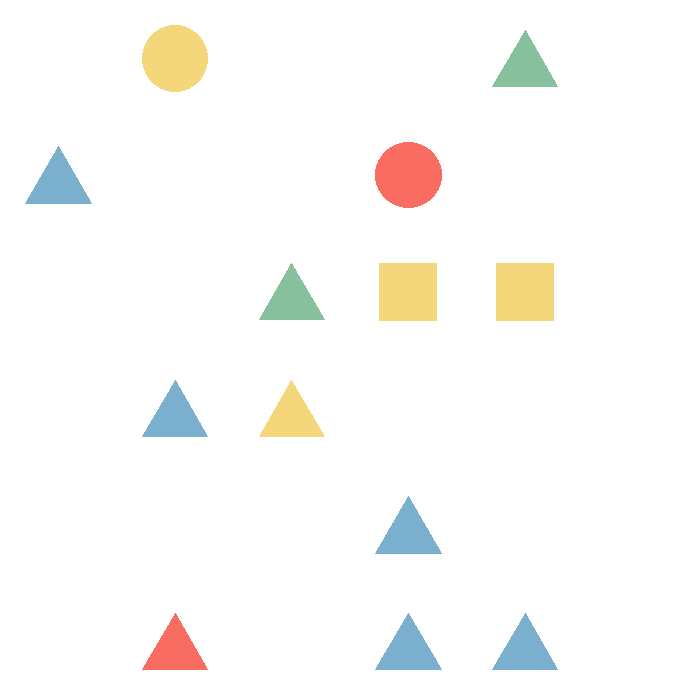

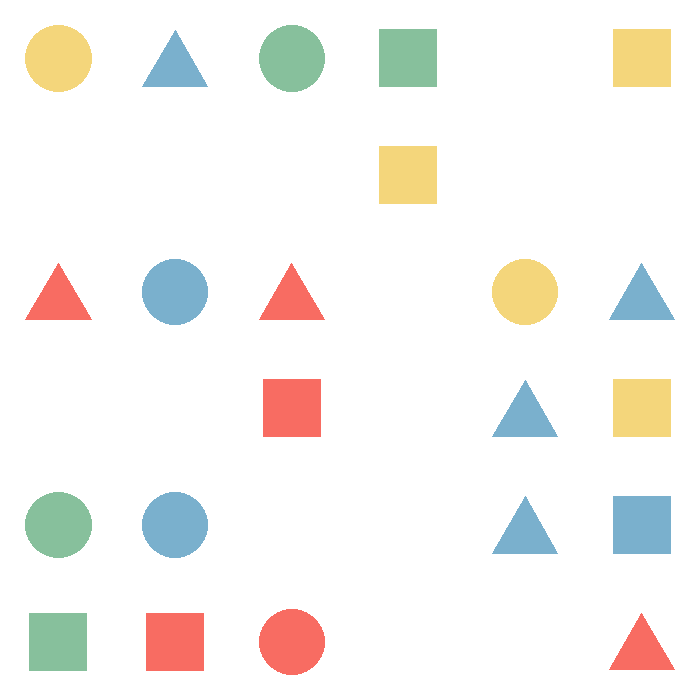

In [ ]:
from PIL import Image
from IPython.display import display, HTML
import os
import json # Import json here as well for completeness

image_dir = os.path.join(db_dir, "img")

# Specify the explanation file for the blue diagonal test dataset
explanation_filename = "exactly_6_red_symbols_test_explanations.json"
output_json_path = os.path.join(db, explanation_filename)

# Check if the explanation file exists before attempting to open
if not os.path.exists(output_json_path):
    print(f"Error: Explanation file not found at {output_json_path}. Please ensure you have generated it.")
else:
    with open(output_json_path) as f:
        explanations = json.load(f)

    # ------------------------------------------------------------------
    # 3.  show some examples
    # ------------------------------------------------------------------
    MAX_SHOW = 10                               # ← change or remove the limit
    for item in explanations[:MAX_SHOW]:
        # Construct the full image path correctly
        img_path = os.path.join(image_dir, Path(item["path"]).name)

        # print(f"Attempting to open image: {img_path}") # Print the path being accessed

        caption  = f"<b>Class {item['class']}</b> — {item['explanation']}"

        # display the image and its caption
        try:
            display(Image.open(img_path).convert("RGB"))
            display(HTML(caption))
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")

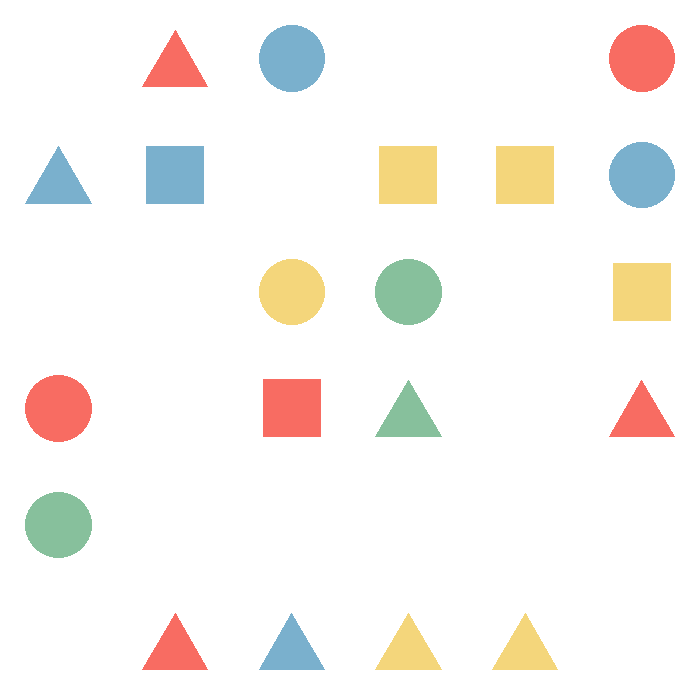

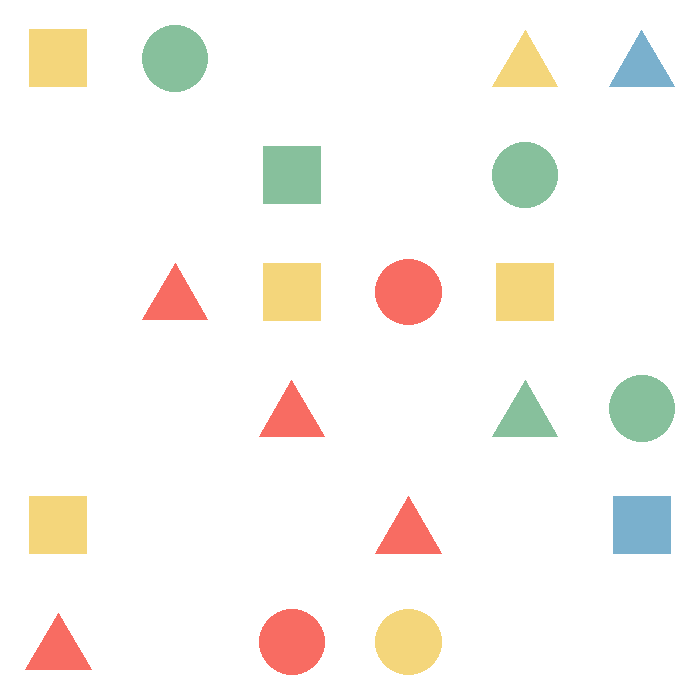

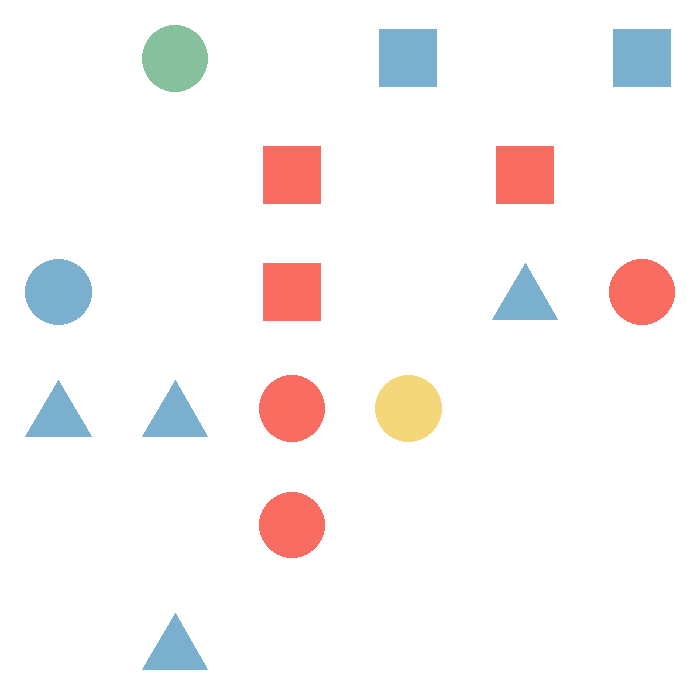

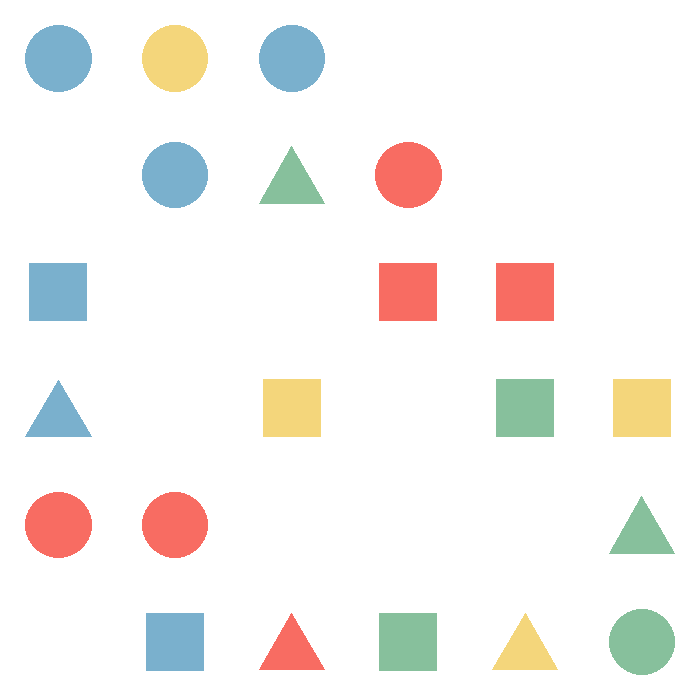

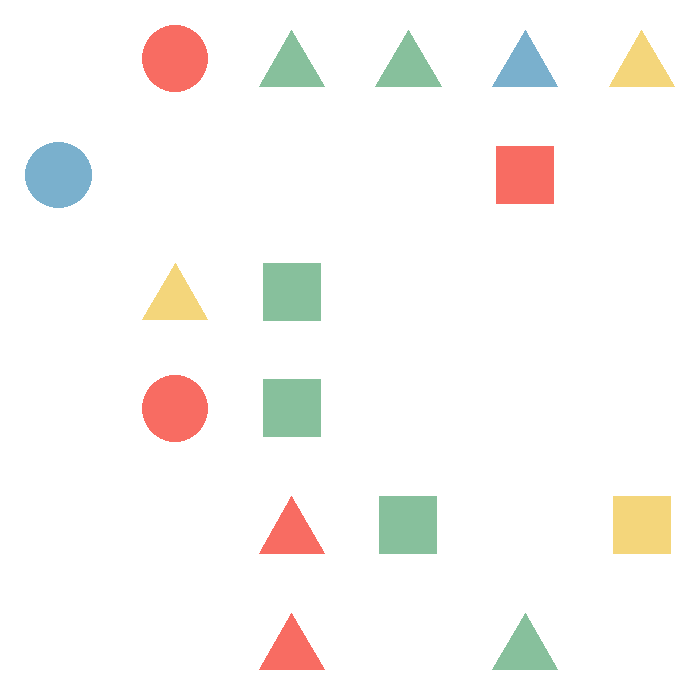

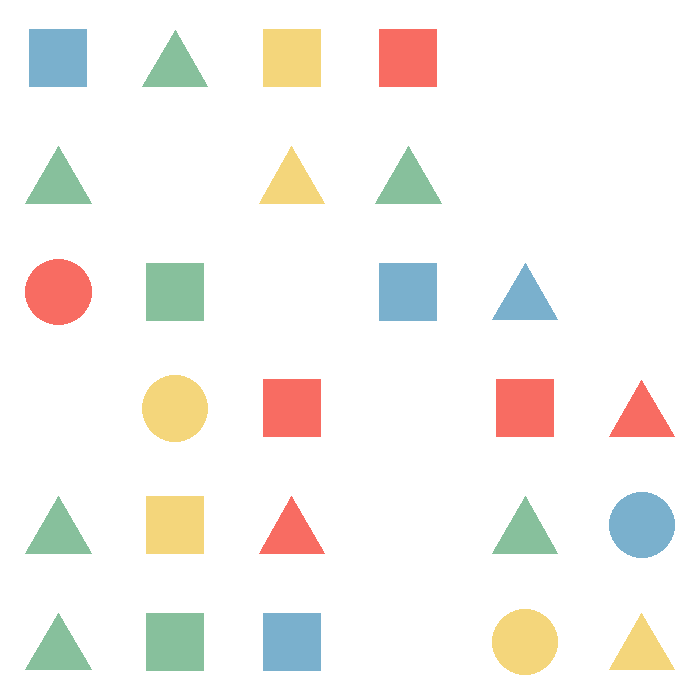

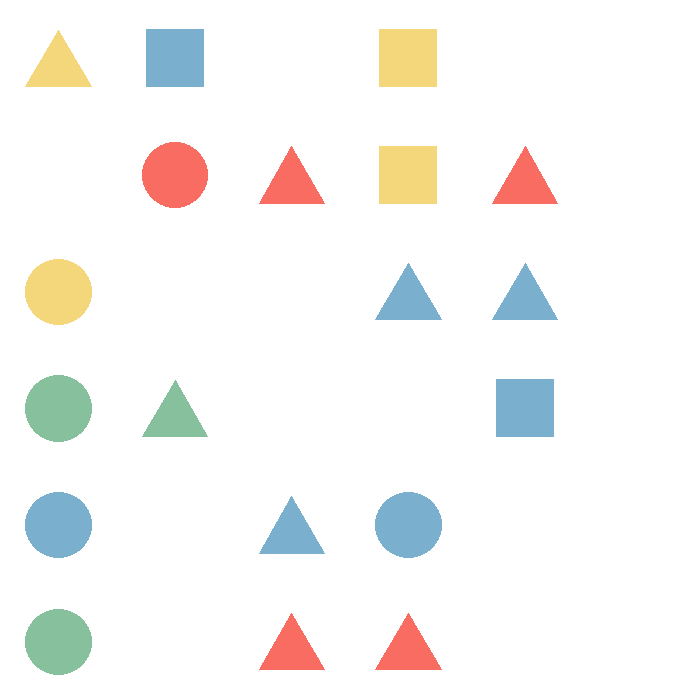

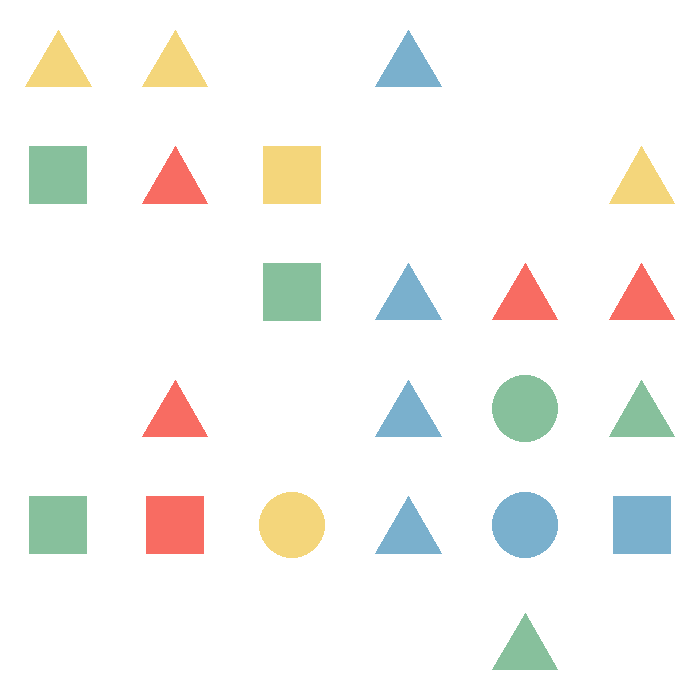

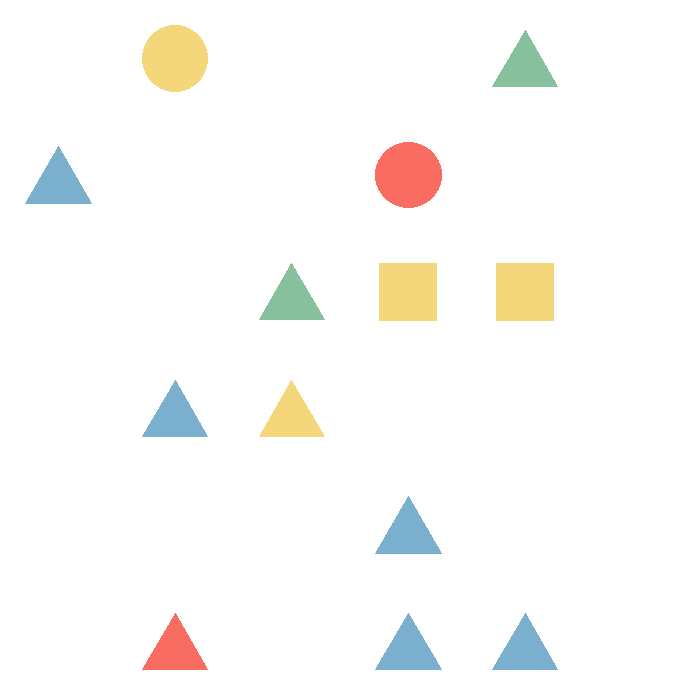

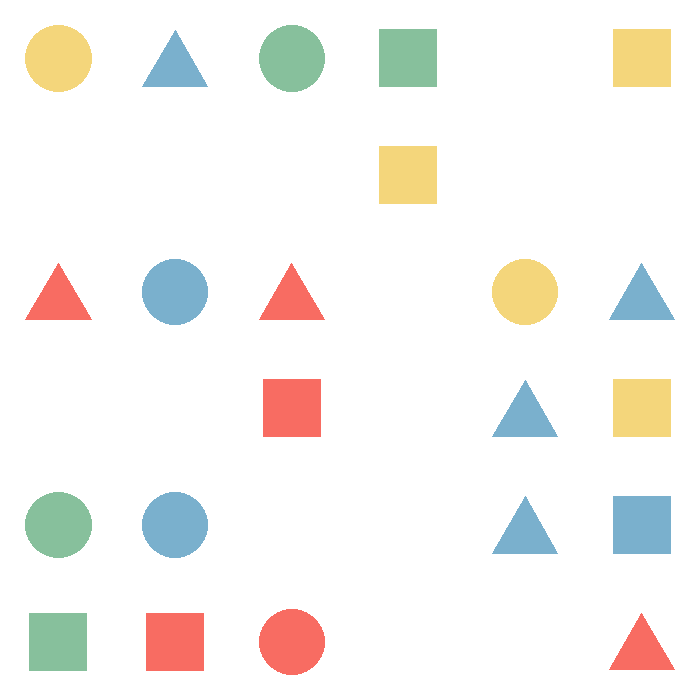

In [ ]:
from PIL import Image
from IPython.display import display, HTML
import os
import json # Import json here as well for completeness

image_dir = os.path.join(db_dir, "img")

# Specify the explanation file for the blue diagonal test dataset
explanation_filename = "exactly_6_red_symbols_test_explanations.json"
output_json_path = os.path.join(db, explanation_filename)

# Check if the explanation file exists before attempting to open
if not os.path.exists(output_json_path):
    print(f"Error: Explanation file not found at {output_json_path}. Please ensure you have generated it.")
else:
    with open(output_json_path) as f:
        explanations = json.load(f)

    # ------------------------------------------------------------------
    # 3.  show some examples
    # ------------------------------------------------------------------
    MAX_SHOW = 10                               # ← change or remove the limit
    for item in explanations[:MAX_SHOW]:
        # Construct the full image path correctly
        img_path = os.path.join(image_dir, Path(item["path"]).name)

        # print(f"Attempting to open image: {img_path}") # Print the path being accessed

        caption  = f"<b>Class {item['class']}</b> — {item['explanation']}"

        # display the image and its caption
        try:
            display(Image.open(img_path).convert("RGB"))
            display(HTML(caption))
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")

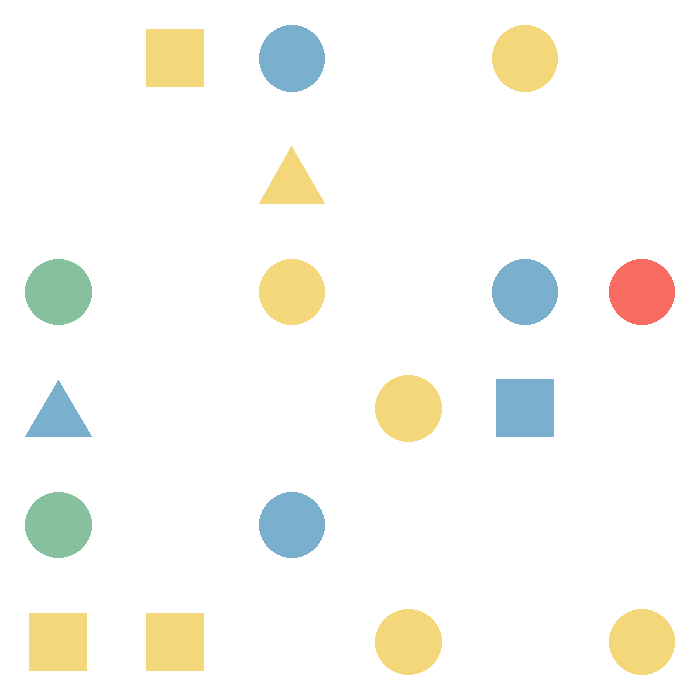

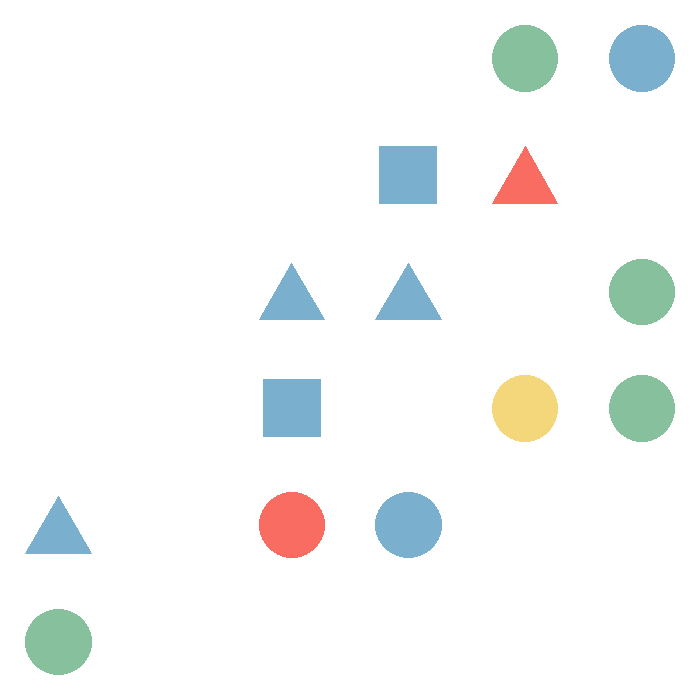

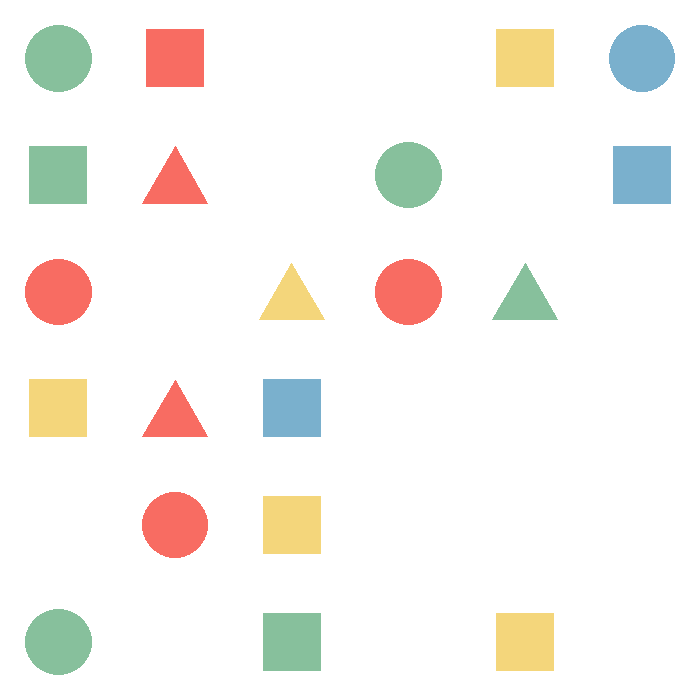

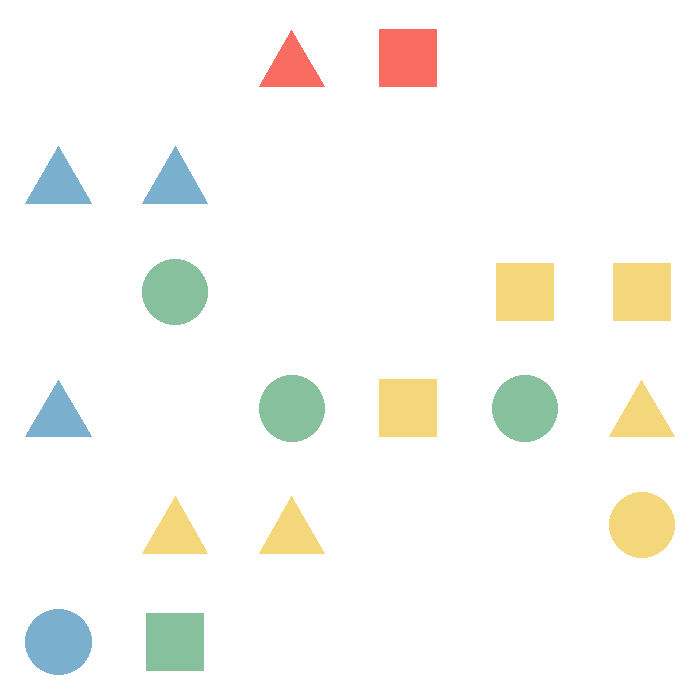

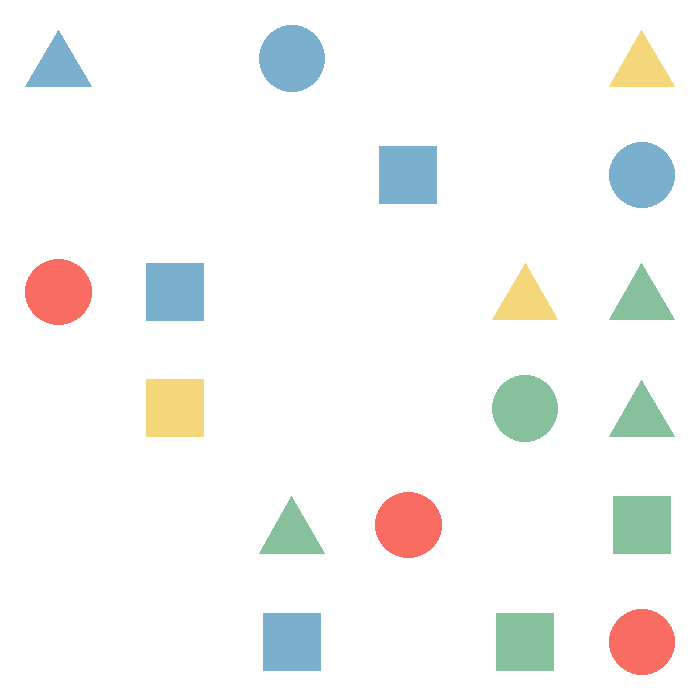

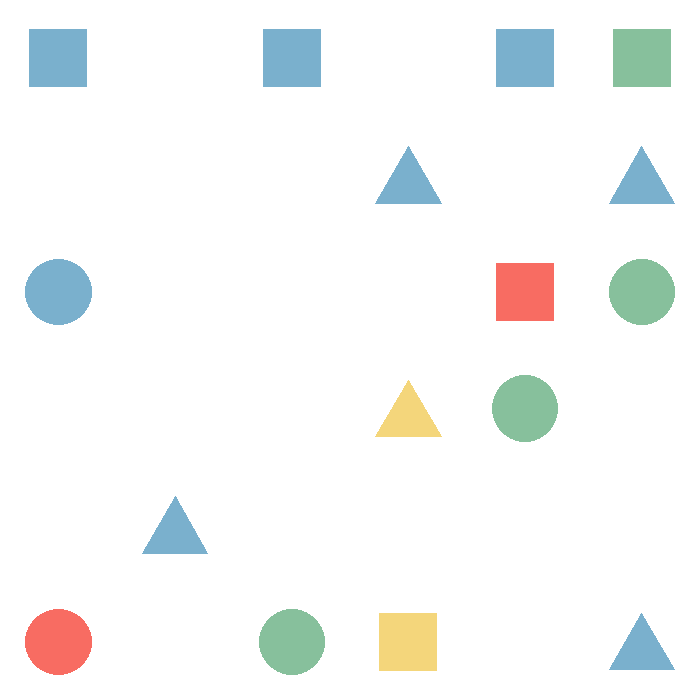

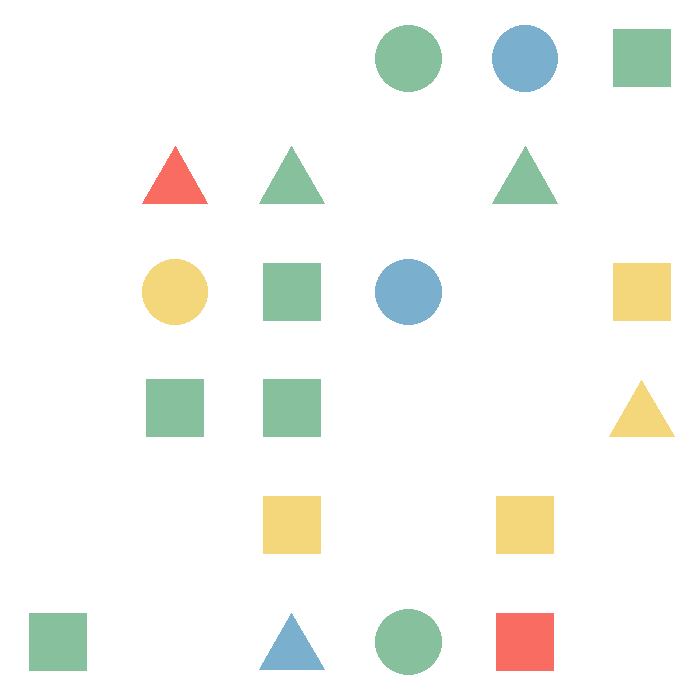

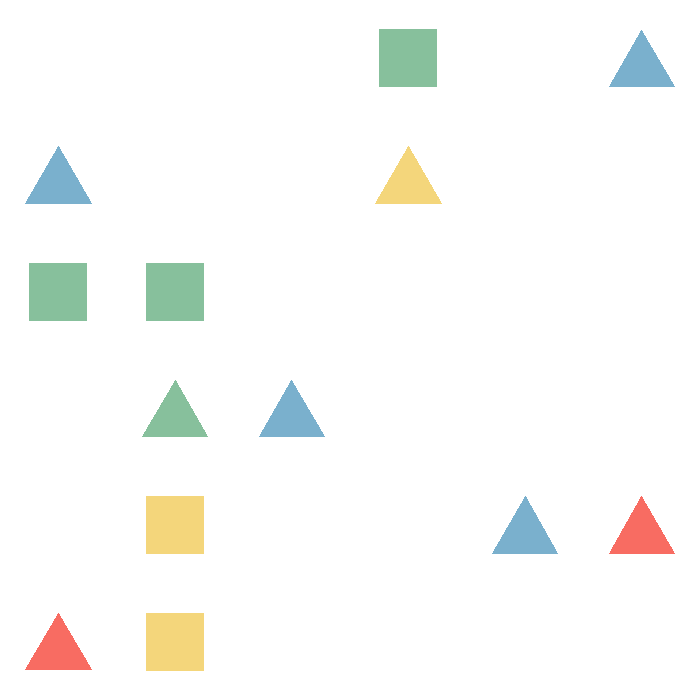

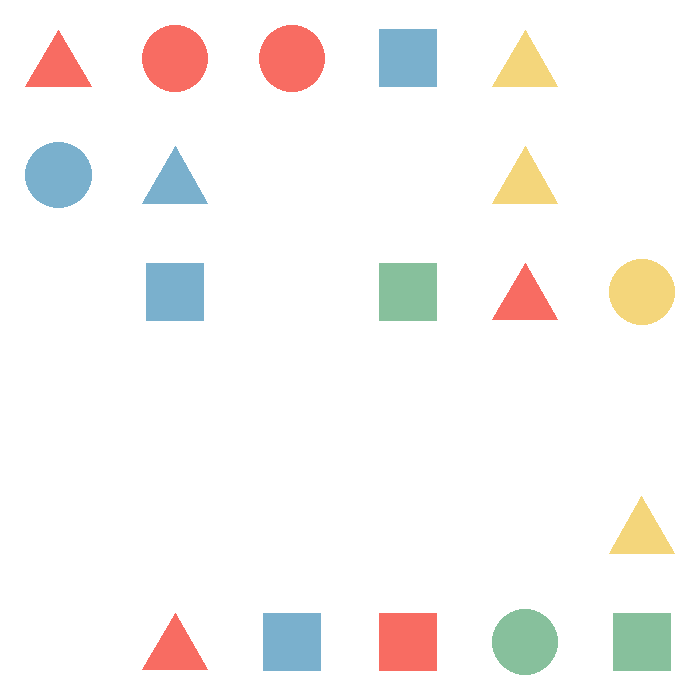

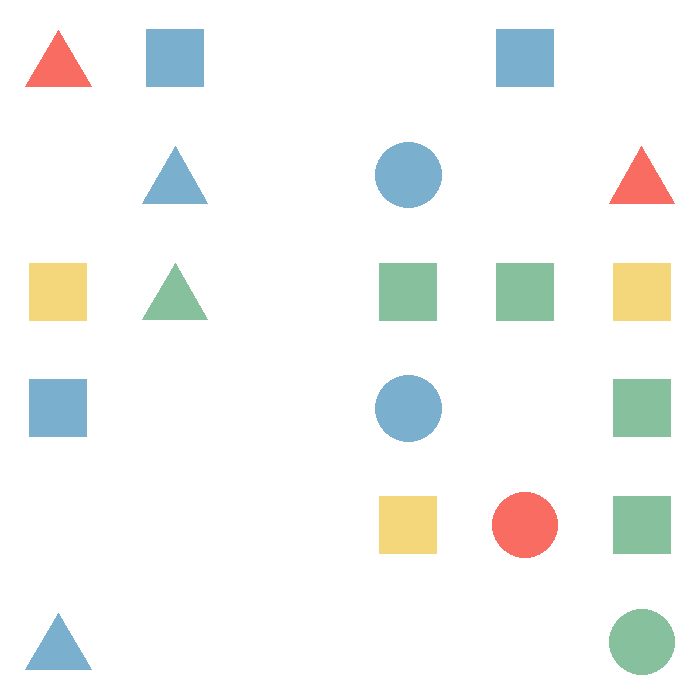

In [ ]:
from PIL import Image
from IPython.display import display, HTML
import os
import json # Import json here as well for completeness

image_dir = os.path.join(db_dir, "img")

# Specify the explanation file for the blue diagonal test dataset
explanation_filename = "twice_as_many_green_as_red_test_explanations.json"
output_json_path = os.path.join(db, explanation_filename)

# Check if the explanation file exists before attempting to open
if not os.path.exists(output_json_path):
    print(f"Error: Explanation file not found at {output_json_path}. Please ensure you have generated it.")
else:
    with open(output_json_path) as f:
        explanations = json.load(f)

    # ------------------------------------------------------------------
    # 3.  show some examples
    # ------------------------------------------------------------------
    MAX_SHOW = 10                               # ← change or remove the limit
    for item in explanations[:MAX_SHOW]:
        # Construct the full image path correctly
        img_path = os.path.join(image_dir, Path(item["path"]).name)

        # print(f"Attempting to open image: {img_path}") # Print the path being accessed

        caption  = f"<b>Class {item['class']}</b> — {item['explanation']}"

        # display the image and its caption
        try:
            display(Image.open(img_path).convert("RGB"))
            display(HTML(caption))
        except FileNotFoundError:
            print(f"Error: Image file not found at {img_path}. Skipping.")
        except Exception as e:
            print(f"An error occurred while processing {img_path}: {e}")

In [ ]:
import shutil

def extract_sample_with_explanations(explanation_json_path, output_dir_path, pos_samples_nb, neg_samples_nb):
    """
    Extracts a sample of images and their explanations from a generated JSON file.
    :param explanation_json_path: path to the JSON file with explanations.
    :param output_dir_path: Path to save the sample dataset.
    :param pos_samples_nb: Number of positive samples to extract.
    :param neg_samples_nb: Number of negative samples to extract.
    """
    if not os.path.isabs(output_dir_path):
        output_dir_path = os.path.join(db, output_dir_path)

    pos_nb = 0
    neg_nb = 0
    pos_dir_path = os.path.join(output_dir_path, "positive")
    neg_dir_path = os.path.join(output_dir_path, "negative")

    # Create directories if they don't exist
    os.makedirs(pos_dir_path, exist_ok=True)
    os.makedirs(neg_dir_path, exist_ok=True)

    full_explanation_json_path = os.path.join(db, explanation_json_path) # Construct full path

    with open(full_explanation_json_path, "r") as f:
        data = json.load(f)

    for item in data:
        img_path = os.path.join(db_dir, item["path"])
        explanation = item["explanation"]
        label = item["class"]
        img_filename = Path(img_path).name
        explanation_filename = Path(img_path).stem + ".txt"

        if label == 1 and pos_nb < pos_samples_nb:
            shutil.copyfile(img_path, os.path.join(pos_dir_path, img_filename))
            with open(os.path.join(pos_dir_path, explanation_filename), "w") as f:
                f.write(explanation)
            pos_nb += 1
        elif label == 0 and neg_nb < neg_samples_nb:
            shutil.copyfile(img_path, os.path.join(neg_dir_path, img_filename))
            with open(os.path.join(neg_dir_path, explanation_filename), "w") as f:
                f.write(explanation)
            neg_nb += 1

    print(f"Extracted {pos_nb} positive and {neg_nb} negative samples to {output_dir_path}")

In [ ]:
extract_sample_with_explanations("bluediagonal_test_explanations.json", "bluediagonal_test_explanation_sample", 20, 20)

Extracted 20 positive and 20 negative samples to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/bluediagonal_test__explanation_sample


In [ ]:
extract_sample_with_explanations("exactly_6_red_symbols_test_explanations.json", "exactly_6_red_symbols_test_explanation_sample", 20, 20)

Extracted 20 positive and 20 negative samples to /content/drive/MyDrive/IMT/InternshipPatImgXAI_data/db0.1.3/datasets/exactly_6_red_symbols_test__explanation_sample


In [ ]:
extract_sample_with_explanations("exactly_6_squares_test_explanations.json", "exactly_6_squares_test_explanation_sample", 20, 20)

In [ ]:
extract_sample_with_explanations("twice_as_many_green_as_red_test_explanations.json", "twice_as_many_green_as_red_test_explanation_sample", 20, 20)